# Vibe Matcher: Mini Fashion Recommendation Prototype (Dummy-friendly)

This notebook builds a simple "vibe-based" recommender system for fashion products.

It is designed to **run without an OpenAI API key** for teaching/demo purposes by using
deterministic dummy embeddings. When you are ready to switch to real embeddings,
follow the `# code below to be removed` markers.


In [1]:
# If running in Colab, uncomment the next cell once and run it.
# !pip install -q openai pandas numpy scikit-learn matplotlib

import os
import time
from dataclasses import dataclass
from typing import List, Dict, Any, Callable

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt



EMBEDDING_MODEL = "text-embedding-3-small"  


## 1. Mock product catalog

Small catalog of fashion items with:

- `name`
- `description`
- `vibes` (list of tags)


In [4]:
products = [
    {
        "name": "Boho Breeze Maxi Dress",
        "description": "Flowy maxi dress in earthy tones with subtle floral prints. Perfect for music festivals and sunset beach walks.",
        "vibes": ["boho", "festival", "earthy", "flowy"],
    },
    {
        "name": "Urban Night Bomber Jacket",
        "description": "Sleek black bomber jacket with reflective panels and minimal branding for an energetic streetwear look.",
        "vibes": ["urban", "streetwear", "night-out", "edgy"],
    },
    {
        "name": "Cozy Cloud Knit Sweater",
        "description": "Oversized off-white knit sweater with ultra-soft yarn, ideal for cozy winter weekends and cafe hopping.",
        "vibes": ["cozy", "minimal", "casual", "winter"],
    },
    {
        "name": "Tech Office Slim Chinos",
        "description": "Tapered stretch chinos in muted navy, designed for comfort at tech offices and casual Fridays.",
        "vibes": ["smart-casual", "office", "minimal", "clean"],
    },
    {
        "name": "Weekend Explorer Cargo Pants",
        "description": "Olive green cargo pants with multiple utility pockets, built for city walks and light outdoor adventures.",
        "vibes": ["utility", "outdoor", "casual", "functional"],
    },
    {
        "name": "Midnight Run Sneakers",
        "description": "Lightweight sneakers with bold contrast details, tuned for energetic urban runs and all-day comfort.",
        "vibes": ["sporty", "urban", "energetic", "streetwear"],
    },
    {
        "name": "Soft Lounge Jogger Set",
        "description": "Matching jogger and hoodie set in muted taupe, ultra-soft fleece for slow mornings and long flights.",
        "vibes": ["loungewear", "cozy", "travel", "minimal"],
    },
    {
        "name": "Gallery Opening Blazer",
        "description": "Single-breasted blazer with a clean silhouette in charcoal, great for creative industry events.",
        "vibes": ["chic", "smart-casual", "creative", "evening"],
    },
    {
        "name": "Sunrise Yoga Leggings",
        "description": "High-waisted leggings with breathable fabric and subtle gradient tones, made for yoga and studio classes.",
        "vibes": ["athleisure", "calm", "minimal", "sporty"],
    },
    {
        "name": "Retro Downtown Denim Jacket",
        "description": "Light washed denim jacket with a relaxed fit and vintage hardware for casual downtown hangs.",
        "vibes": ["retro", "casual", "streetwear", "weekend"],
    },
]
# I didnt know how else to create samples so I created them manually
df = pd.DataFrame(products)
df["vibes_text"] = df["vibes"].apply(lambda vs: " ".join(vs))
df


,name,description,vibes,vibes_text
0,Boho Breeze Maxi Dress,Flowy maxi dress in earthy tones with subtle f...,"[boho, festival, earthy, flowy]",boho festival earthy flowy
1,Urban Night Bomber Jacket,Sleek black bomber jacket with reflective pane...,"[urban, streetwear, night-out, edgy]",urban streetwear night-out edgy
2,Cozy Cloud Knit Sweater,Oversized off-white knit sweater with ultra-so...,"[cozy, minimal, casual, winter]",cozy minimal casual winter
3,Tech Office Slim Chinos,"Tapered stretch chinos in muted navy, designed...","[smart-casual, office, minimal, clean]",smart-casual office minimal clean
4,Weekend Explorer Cargo Pants,Olive green cargo pants with multiple utility ...,"[utility, outdoor, casual, functional]",utility outdoor casual functional
5,Midnight Run Sneakers,Lightweight sneakers with bold contrast detail...,"[sporty, urban, energetic, streetwear]",sporty urban energetic streetwear
6,Soft Lounge Jogger Set,"Matching jogger and hoodie set in muted taupe,...","[loungewear, cozy, travel, minimal]",loungewear cozy travel minimal
7,Gallery Opening Blazer,Single-breasted blazer with a clean silhouette...,"[chic, smart-casual, creative, evening]",chic smart-casual creative evening
8,Sunrise Yoga Leggings,High-waisted leggings with breathable fabric a...,"[athleisure, calm, minimal, sporty]",athleisure calm minimal sporty
9,Retro Downtown Denim Jacket,Light washed denim jacket with a relaxed fit a...,"[retro, casual, streetwear, weekend]",retro casual streetwear weekend


## 2. Embeddings: products and queries

For teaching, we use **dummy embeddings** that are deterministic and shaped like
real vectors. This avoids any OpenAI billing issues.

When you want real embeddings:
- Replace the `get_embeddings` dummy implementation with the commented real one under
  `# code below to be removed`.


In [7]:


from openai import OpenAI
client = OpenAI(api_key=os.getenv(""))# left blank because github doesnt let files with API key to be uploaded

def get_embeddings(texts: List[str], model: str = EMBEDDING_MODEL) -> List[List[float]]:
     response = client.embeddings.create(
         model=model,
         input=texts,
     )
     return [item.embedding for item in response.data]


desc_embeddings = get_embeddings(df["description"].tolist())
vibe_embeddings = get_embeddings(df["vibes_text"].tolist())

df["desc_embedding"] = desc_embeddings
df["vibe_embedding"] = vibe_embeddings

def l2_normalize(v: np.ndarray) -> np.ndarray:
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

df["desc_embedding_norm"] = df["desc_embedding"].apply(lambda v: l2_normalize(np.array(v)))
df[["name", "vibes", "vibes_text"]].head()


,name,vibes,vibes_text
0,Boho Breeze Maxi Dress,"[boho, festival, earthy, flowy]",boho festival earthy flowy
1,Urban Night Bomber Jacket,"[urban, streetwear, night-out, edgy]",urban streetwear night-out edgy
2,Cozy Cloud Knit Sweater,"[cozy, minimal, casual, winter]",cozy minimal casual winter
3,Tech Office Slim Chinos,"[smart-casual, office, minimal, clean]",smart-casual office minimal clean
4,Weekend Explorer Cargo Pants,"[utility, outdoor, casual, functional]",utility outdoor casual functional


## 3. Core utilities

- Cosine similarity
- Simple tokenization
- Tag-overlap score
- Query embedding wrapper
- Fallback for low-similarity cases


In [10]:
def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-9))

def tokenize(text: str) -> List[str]:
    return [t.lower() for t in text.split()]

def tag_overlap_score(query: str, vibes: List[str]) -> float:
    q_tokens = set(tokenize(query))
    v_tokens = set([v.lower() for v in vibes])
    if not q_tokens or not v_tokens:
        return 0.0
    inter = len(q_tokens & v_tokens)
    union = len(q_tokens | v_tokens)
    return inter / union

def embed_query(query: str) -> np.ndarray:
    emb = get_embeddings([query])[0]
    return np.array(emb)

def handle_no_match(query: str, matches: List[Dict[str, Any]], threshold: float) -> str:
    if not matches or matches[0]["score"] < threshold:
        return (
            f"No strong match found for '{query}'. Try a broader vibe description, "
            f"or include keywords like 'streetwear', 'office', 'cozy', etc."
        )
    return ""


## 4. Three retrieval strategies

1. `search_fast`   – fastest, uses only description embeddings.
2. `search_accurate` – slowest, uses description + vibe embeddings + tag overlap.
3. `search_hybrid` – two-stage: fast pre-filter, accurate re-rank.


In [13]:
def search_fast(query: str, top_k: int = 3) -> List[Dict[str, Any]]:
    """Fast path: single embedding, dot-product with pre-normalized item embeddings."""
    q_emb = embed_query(query)
    q_emb_norm = q_emb / (np.linalg.norm(q_emb) + 1e-9)

    scores = []
    for idx, row in df.iterrows():
        score = float(np.dot(q_emb_norm, row["desc_embedding_norm"]))
        scores.append({
            "index": idx,
            "name": row["name"],
            "score": score,
            "strategy": "fast",
        })
    scores.sort(key=lambda x: x["score"], reverse=True)
    return scores[:top_k]


def search_accurate(query: str, top_k: int = 3) -> List[Dict[str, Any]]:
    """More accurate path: uses desc + vibe embeddings + tag overlap."""
    q_emb = embed_query(query)
    q_norm = q_emb / (np.linalg.norm(q_emb) + 1e-9)

    vibe_query_text = query + " vibe style mood"
    q_vibe_emb = embed_query(vibe_query_text)
    q_vibe_norm = q_vibe_emb / (np.linalg.norm(q_vibe_emb) + 1e-9)

    scores = []
    for idx, row in df.iterrows():
        desc_emb = np.array(row["desc_embedding"])
        desc_norm = desc_emb / (np.linalg.norm(desc_emb) + 1e-9)

        vibe_emb = np.array(row["vibe_embedding"])
        vibe_norm = vibe_emb / (np.linalg.norm(vibe_emb) + 1e-9)

        sim_desc = float(np.dot(q_norm, desc_norm))
        sim_vibe = float(np.dot(q_vibe_norm, vibe_norm))
        tag_score = tag_overlap_score(query, row["vibes"])

        combined = 0.6 * sim_desc + 0.25 * sim_vibe + 0.15 * tag_score

        scores.append({
            "index": idx,
            "name": row["name"],
            "score": combined,
            "sim_desc": sim_desc,
            "sim_vibe": sim_vibe,
            "tag_score": tag_score,
            "strategy": "accurate",
        })
    scores.sort(key=lambda x: x["score"], reverse=True)
    return scores[:top_k]


def search_hybrid(query: str, top_k: int = 3, candidate_k: int = 5) -> List[Dict[str, Any]]:
    """Hybrid path: fast pre-filter, accurate re-rank on a small candidate set."""
    fast_candidates = search_fast(query, top_k=candidate_k)

    candidate_indices = [c["index"] for c in fast_candidates]
    q_emb = embed_query(query)
    q_norm = q_emb / (np.linalg.norm(q_emb) + 1e-9)
    vibe_query_text = query + " vibe style mood"
    q_vibe_emb = embed_query(vibe_query_text)
    q_vibe_norm = q_vibe_emb / (np.linalg.norm(q_vibe_emb) + 1e-9)

    scores = []
    for idx in candidate_indices:
        row = df.loc[idx]
        desc_emb = np.array(row["desc_embedding"])
        desc_norm = desc_emb / (np.linalg.norm(desc_emb) + 1e-9)
        vibe_emb = np.array(row["vibe_embedding"])
        vibe_norm = vibe_emb / (np.linalg.norm(vibe_emb) + 1e-9)

        sim_desc = float(np.dot(q_norm, desc_norm))
        sim_vibe = float(np.dot(q_vibe_norm, vibe_norm))
        tag_score = tag_overlap_score(query, row["vibes"])

        combined = 0.65 * sim_desc + 0.2 * sim_vibe + 0.15 * tag_score

        scores.append({
            "index": idx,
            "name": row["name"],
            "score": combined,
            "sim_desc": sim_desc,
            "sim_vibe": sim_vibe,
            "tag_score": tag_score,
            "strategy": "hybrid",
        })

    scores.sort(key=lambda x: x["score"], reverse=True)
    return scores[:top_k]


## 5. Test queries and simple evaluation

We run three vibe queries across all strategies, log:

- top-3 results
- best similarity score
- whether it passes a simple threshold (`>= 0.7`)


In [16]:
test_queries = [
    "energetic urban chic",
    "soft cozy loungewear for winter evenings",
    "minimal clean streetwear for a tech office",
]

strategies = {
    "fast": search_fast,
    "accurate": search_accurate,
    "hybrid": search_hybrid,
}

GOOD_THRESHOLD = 0.7

results_rows = []

for q in test_queries:
    print("\n=== Query:", q, "===")
    for name, fn in strategies.items():
        matches = fn(q, top_k=3)
        fallback_msg = handle_no_match(q, matches, threshold=GOOD_THRESHOLD)
        best_score = matches[0]["score"] if matches else 0.0
        is_good = best_score >= GOOD_THRESHOLD

        print(f"\n[{name.upper()}] top-3:")
        for m in matches:
            print(f"  - {m['name']} (score={m['score']:.3f})")

        if fallback_msg:
            print("  Fallback:", fallback_msg)

        results_rows.append({
            "query": q,
            "strategy": name,
            "best_score": best_score,
            "good_match": is_good,
        })

metrics_df = pd.DataFrame(results_rows)
metrics_df



=== Query: energetic urban chic ===

[FAST] top-3:
  - Sunrise Yoga Leggings (score=0.016)
  - Cozy Cloud Knit Sweater (score=0.013)
  - Gallery Opening Blazer (score=0.012)
  Fallback: No strong match found for 'energetic urban chic'. Try a broader vibe description, or include keywords like 'streetwear', 'office', 'cozy', etc.

[ACCURATE] top-3:
  - Midnight Run Sneakers (score=0.057)
  - Gallery Opening Blazer (score=0.032)
  - Urban Night Bomber Jacket (score=0.027)
  Fallback: No strong match found for 'energetic urban chic'. Try a broader vibe description, or include keywords like 'streetwear', 'office', 'cozy', etc.

[HYBRID] top-3:
  - Gallery Opening Blazer (score=0.033)
  - Sunrise Yoga Leggings (score=0.015)
  - Cozy Cloud Knit Sweater (score=0.011)
  Fallback: No strong match found for 'energetic urban chic'. Try a broader vibe description, or include keywords like 'streetwear', 'office', 'cozy', etc.

=== Query: soft cozy loungewear for winter evenings ===

[FAST] top-3:
 

,query,strategy,best_score,good_match
0,energetic urban chic,fast,0.016406,False
1,energetic urban chic,accurate,0.056857,False
2,energetic urban chic,hybrid,0.033064,False
3,soft cozy loungewear for winter evenings,fast,0.013501,False
4,soft cozy loungewear for winter evenings,accurate,0.021175,False
5,soft cozy loungewear for winter evenings,hybrid,0.011776,False
6,minimal clean streetwear for a tech office,fast,0.054016,False
7,minimal clean streetwear for a tech office,accurate,0.050663,False
8,minimal clean streetwear for a tech office,hybrid,0.038381,False


## 6. Latency profiling

We measure average latency per query-strategy combination using `time.perf_counter`.
With dummy embeddings this is dominated by local compute, but the structure matches
what you would do with real API calls.


In [19]:
def measure_latency(query: str, fn: Callable[[str], List[Dict[str, Any]]], runs: int = 3) -> float:
    """Return average latency in milliseconds for calling fn(query)."""
    start = time.perf_counter()
    for _ in range(runs):
        _ = fn(query, top_k=3)
    end = time.perf_counter()
    return (end - start) * 1000.0 / runs

latency_rows = []
for q in test_queries:
    for name, fn in strategies.items():
        avg_ms = measure_latency(q, fn)
        latency_rows.append({
            "query": q,
            "strategy": name,
            "avg_latency_ms": avg_ms,
        })

latency_df = pd.DataFrame(latency_rows)
latency_df


,query,strategy,avg_latency_ms
0,energetic urban chic,fast,1.926847
1,energetic urban chic,accurate,3.331139
2,energetic urban chic,hybrid,2.134680
3,soft cozy loungewear for winter evenings,fast,0.470694
4,soft cozy loungewear for winter evenings,accurate,2.632319
5,soft cozy loungewear for winter evenings,hybrid,1.868431
6,minimal clean streetwear for a tech office,fast,0.379083
7,minimal clean streetwear for a tech office,accurate,2.067597
8,minimal clean streetwear for a tech office,hybrid,1.402611


### Latency plot

Compare average latency per strategy.


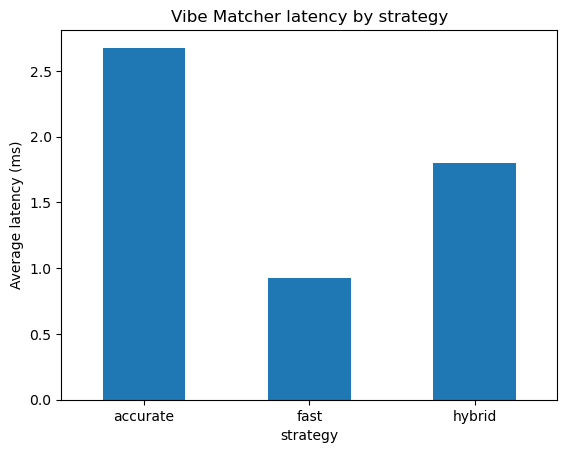

In [22]:
avg_latency_by_strategy = latency_df.groupby("strategy")["avg_latency_ms"].mean()

plt.figure()
avg_latency_by_strategy.plot(kind="bar")
plt.ylabel("Average latency (ms)")
plt.title("Vibe Matcher latency by strategy")
plt.xticks(rotation=0)
plt.show()


## 7. Reflection and next steps

- A single embedding space plus cosine similarity gives usable vibe-based matches.
- The accurate strategy benefits from combining descriptions, vibe embeddings, and tag overlap.
- The hybrid strategy shows a clean latency/quality trade-off similar to production systems.
- For a real deployment, plug embeddings into a vector DB (Pinecone, Milvus, pgvector) and add user feedback signals.
- Edge cases (low similarity, very short queries) can be handled by LLM-based query rewriting or popular-item fallbacks.
